# Análise Exploratória de Dados

DATASET: Sistema de Informações InfoÁguas da Companhia Ambiental do Estado de São Paulo - CETESB.

OBJETIVO: Visa disponibilizar ao público interessado informações sobre a qualidade das águas do Estado de São Paulo quanto aos Índices de Qualidade das Águas  Superficiais e aos resultados dos parâmetros analisados sistematicamente pela CETESB.

LOCALIZAÇÃO: Unidades de Gerenciamento de Recursos Hidricos (UGRHIs) - 2, 5, 6, 7 e 10 - classificada pela CETESB como área industrializada.

PERÍODO DA COLETA DE DADOS: 1977 à 2019.

DESCRIÇÃO DO DATASET: O dataset original da CETESB baixado da ferramenta web infoáguas, apresenta 26 colunas e aproximadamente 4200 linhas. As colunas dizem respeito basicamente a periodicidade do monitoramento, a localização dos pontos, a situação atual dos pontos (ativo ou não), os parametros e qual o tipo de paramentro (fisico, quimico, microbiologico e outros). Optamos por escolher a área classificada como industrializada pois esta área apresentou uma quantidade de dados adequada para a execução do experimento.

O projeto de pesquisa que tem como objetivo geral predizer parametros da qualidade da água usando aprendizado de máquina, dessa forma, tratamos o conjunto de dados como uma série temporal, assim, a predição retornará o valor do parametro para um período de tempo futuro.

Dessa forma, descrevemos as etapas executadas:



In [1]:
#Carrega o arquivo com os dados e mostra parte do seu conteúdo
from datetime import datetime
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import math
from pandas.plotting import register_matplotlib_converters

In [2]:
str_files = '../data/CETESB/'

parameters_WQ = ['coliformes', 'dbo', 'Fosforo', 'nitrogenio', 'od', 'ph', 'solido', 'temperatura', 'turbidez']
parameters_WQ_name = ['Coliformes Termotolerantes', 'DBO (5, 20)', 'Fósforo Total', 'Nitrogênio Total', 'Oxigênio Dissolvido',
                      'pH', 'Sólido Total', 'Temperatura da Água', 'Turbidez']

param_WQ = 'ph'

df = pd.read_csv(str_files + param_WQ + '.CSV',encoding='utf-8',sep=';')
print(df.dtypes)

periodode                object
periodoate               object
cod_interaguas            int64
tipo_rede                object
UGRHI                    object
codigo_ponto             object
status_ponto             object
data_coleta              object
hora_coleta              object
parametro                object
sinal                   float64
valor                   float64
unidade                  object
tipo_parametro           object
sistema_hidrico          object
tipo_sistema_hidrico     object
classe                   object
municipio                object
uf                       object
inicio_operacao          object
fim_operacao             object
Latitude                 object
Longitude                object
Altitude                  int64
Localizacao              object
Captacao                 object
dtype: object


Plotagem da série temporal referente ao período de 1977 à 2019.


/home/marcos/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


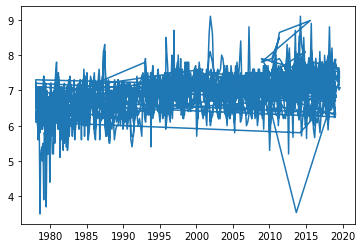

In [3]:
print("Plotagem da série temporal referente ao período de 1977 à 2019.")
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + param_WQ + '.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)
ts = df['valor']
plt.plot(ts)

In [4]:
print("Executa o teste de estacionariedade, na qual verifica se a média e a variância são constantes durante o tempo. \n É estacionária quando o valor do teste é menor que 0.05.")
X = df['valor']
result = adfuller(X)
print("Valor de P: %f" % result[1])

Executa o teste de estacionariedade, na qual verifica se a média e a variância são constantes durante o tempo. 
 É estacionária quando o valor do teste é menor que 0.05.
Valor de P: 0.000001


Agrupamento dos dados por UGRHI 
 Podemos perceber que de 1980 a 2000 não há dados de todas as UGRHI. 
 Portanto, vamos separar os dados referente ao período de 2000 a 2019.


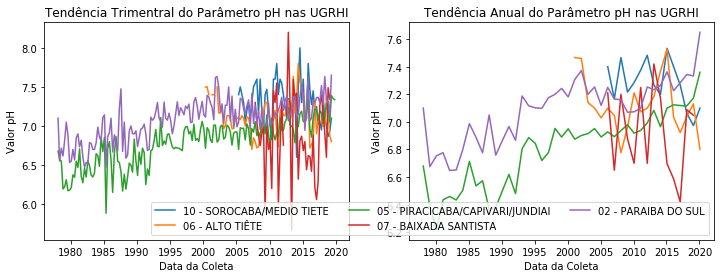

In [87]:
print("Agrupamento dos dados por UGRHI \n Podemos perceber que de 1980 a 2000 não há dados de todas as UGRHI. \n Portanto, vamos separar os dados referente ao período de 2000 a 2019.")
UGRHI = df.UGRHI.values
tdf = df.copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(tdf[tdf.UGRHI.isin(UGRHI)].groupby([pd.Grouper(freq='3M'), 'UGRHI'])['valor'].mean().unstack())
ax1.set_title('Tendência Trimentral do Parâmetro pH nas UGRHI')
ax1.set_xlabel('Data da Coleta')
ax1.set_ylabel('Valor pH')

ax2.plot(tdf[tdf.UGRHI.isin(UGRHI)].groupby([pd.Grouper(freq='12M'), 'UGRHI'])['valor'].mean().unstack())
ax2.set_title('Tendência Anual do Parâmetro pH nas UGRHI')
ax2.set_xlabel('Data da Coleta')
ax2.set_ylabel('Valor pH')

ax2.legend(df.UGRHI.unique(), ncol=3,
          loc='lower right')

# loc='upper center',
#           ncol=3, fancybox=True, shadow=True
    
# plt.text(0.5, 0.95, 'test', transform=fig.transFigure, horizontalalignment='center')
plt.show()

In [54]:
print("Observando o comportamento da serie temporal no período de 2003 a 2019")
pts = ts['2003-01-01':'2019-12-31']
print(pts)
plt.plot(pts.unstack())

Observando o comportamento da serie temporal no período de 2003 a 2019
data_coleta
2003-01-14    7.10
2003-03-11    7.10
2003-05-13    6.90
2003-07-29    7.20
2003-09-09    7.40
              ... 
2019-04-25    7.41
2019-05-16    7.43
2019-06-06    7.58
2019-07-04    7.17
2019-08-01    7.39
Name: valor, Length: 2037, dtype: float64


AttributeError: 'DatetimeIndex' object has no attribute 'remove_unused_levels'

Foi executado a decomposição da serie temporal abrangendo valor mensal do período de 01/01/2003 a 31/12/2019.
A configuração da decomposição da serie temporal considerou a frequência bimestral.
O teste de estacionariedade resultou que a série temporal original é estacionária, dessa forma, não apresenta tendência, entretanto apresenta sazonalidade.


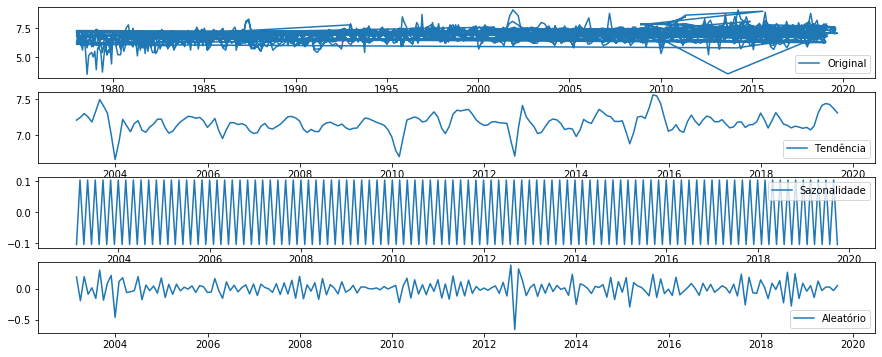

In [248]:
print("Foi executado a decomposição da serie temporal abrangendo valor mensal do período de 01/01/2003 a 31/12/2019.")
print("A configuração da decomposição da serie temporal considerou a frequência bimestral.")
print("O teste de estacionariedade resultou que a série temporal original é estacionária, dessa forma, não apresenta tendência, entretanto apresenta sazonalidade.")

#decomposicao = seasonal_decompose(pts_mes,freq=12, extrapolate_trend = 12)
decomposicao = seasonal_decompose(pts_mes,freq=2)
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal
aleatorio = decomposicao.resid

plt.subplot(4,1,1)
plt.plot(ts,label='Original')
plt.legend(loc='best')

plt.subplot(4,1,2)
plt.plot(tendencia,label='Tendência')
plt.legend(loc='best')

plt.subplot(4,1,3)
plt.plot(sazonal,label='Sazonalidade')
plt.legend(loc='best')

plt.subplot(4,1,4)
plt.plot(aleatorio,label='Aleatório')
plt.legend(loc='best')


In [249]:
print("Predição do valor de PH utilizando redes neurais MLP (Multipla Camada)\n Registros no período de 2003 a 2019.")
pts_valor = pts.values
pts_valor = pts_valor.astype('float32')

Predição do valor de PH utilizando redes neurais MLP (Multipla Camada)
 Registros no período de 2003 a 2019.


Numero de observações (dados de treino, dados de teste): (1425, 612)


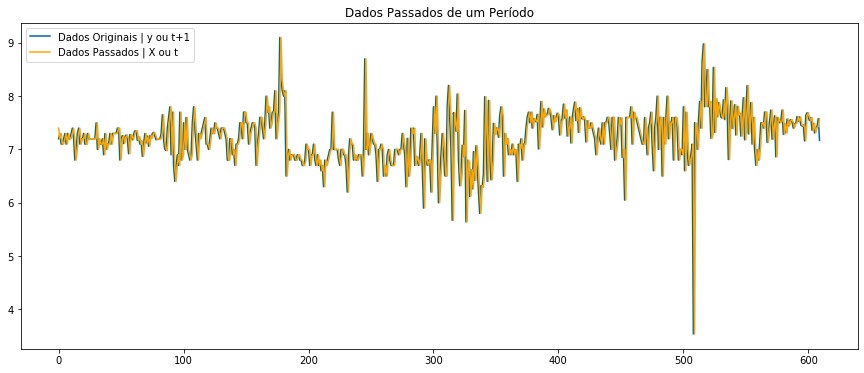

In [250]:
TRAIN_SIZE = 0.70
train_size = int(len(pts_valor) * TRAIN_SIZE)
test_size = len(pts_valor) - train_size
train, test = pts_valor[0:train_size], pts_valor[train_size:len(pts_valor)]
print('Numero de observações (dados de treino, dados de teste): ' + str((len(train),len(test))))

def prepare_data(data, lags=1):
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags)]
        X.append(a)
        y.append(data[row + lags])
    return np.array(X), np.array(y) 

lags = 1
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test

plt.plot(y_test, label='Dados Originais | y ou t+1', color='#006699')
plt.plot(X_test, label='Dados Passados | X ou t', color='orange')
plt.legend(loc='upper left')
plt.title('Dados Passados de um Período')
plt.show()

In [251]:
mdl = Sequential()
mdl.add(Dense(4, input_dim=lags, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=100, batch_size=2, verbose=2)

Train on 1423 samples
Epoch 1/100
1423/1423 - 3s - loss: 68.3278
Epoch 2/100
1423/1423 - 2s - loss: 0.8194
Epoch 3/100
1423/1423 - 2s - loss: 0.0925
Epoch 4/100
1423/1423 - 2s - loss: 0.0928
Epoch 5/100
1423/1423 - 2s - loss: 0.0925
Epoch 6/100
1423/1423 - 2s - loss: 0.0931
Epoch 7/100
1423/1423 - 2s - loss: 0.0929
Epoch 8/100
1423/1423 - 2s - loss: 0.0937
Epoch 9/100
1423/1423 - 2s - loss: 0.0933
Epoch 10/100
1423/1423 - 2s - loss: 0.0934
Epoch 11/100
1423/1423 - 2s - loss: 0.0940
Epoch 12/100
1423/1423 - 2s - loss: 0.0934
Epoch 13/100
1423/1423 - 2s - loss: 0.0931
Epoch 14/100
1423/1423 - 2s - loss: 0.0931
Epoch 15/100
1423/1423 - 2s - loss: 0.0929
Epoch 16/100
1423/1423 - 2s - loss: 0.0939
Epoch 17/100
1423/1423 - 2s - loss: 0.0926
Epoch 18/100
1423/1423 - 2s - loss: 0.0920
Epoch 19/100
1423/1423 - 2s - loss: 0.0940
Epoch 20/100
1423/1423 - 2s - loss: 0.0935
Epoch 21/100
1423/1423 - 2s - loss: 0.0923
Epoch 22/100
1423/1423 - 2s - loss: 0.0927
Epoch 23/100
1423/1423 - 2s - loss: 0.09

In [252]:
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Pontuação de teste: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Pontuação de Treino: 0.09 MSE (0.30 RMSE)
Pontuação de teste: 0.18 MSE (0.42 RMSE)


In [253]:
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

In [254]:
train_predict_plot = np.empty_like(pts_valor)
train_predict_plot = np.reshape(train_predict_plot,(train_predict_plot.shape[0],1))
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

In [255]:
test_predict_plot = np.empty_like(pts_valor)
test_predict_plot = np.reshape(test_predict_plot,(test_predict_plot.shape[0],1))
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(pts_valor)-1, :] = test_predict

In [256]:
valor_predito = np.concatenate((train_predict,test_predict),axis=None)
phts = ts['2003-01-01':'2019-12-31']

for i in range(len(valor_predito)):
    phts[i] = valor_predito[i];

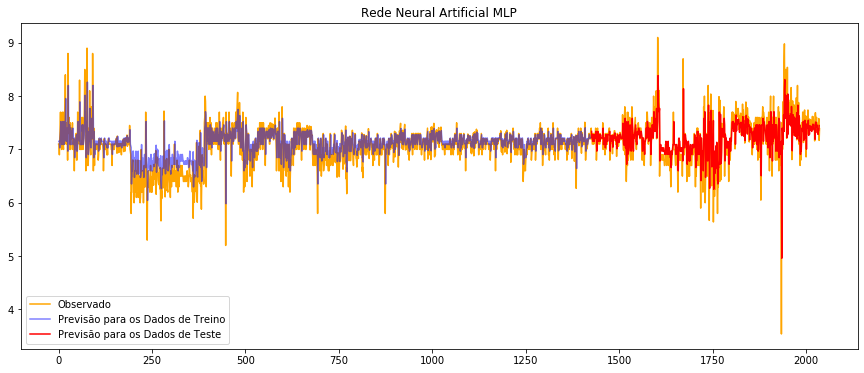

In [257]:
plt.plot(pts_valor, label='Observado', color='orange');
plt.plot(train_predict_plot, label='Previsão para os Dados de Treino', color='blue', alpha=0.5);
plt.plot(test_predict_plot, label='Previsão para os Dados de Teste', color='red');
plt.legend(loc='best');
plt.title('Rede Neural Artificial MLP')
plt.show()

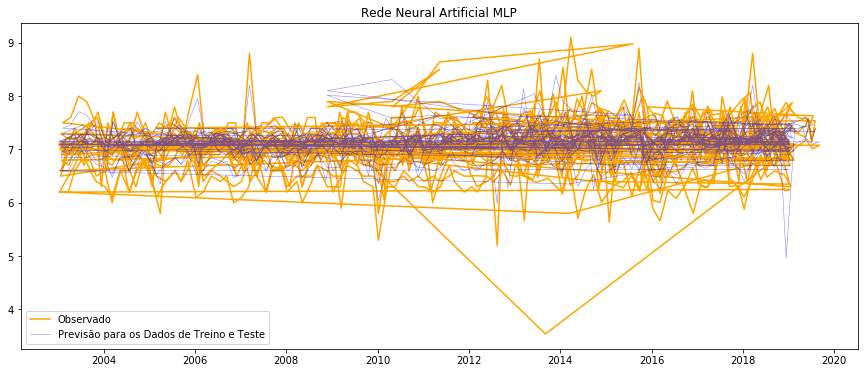

In [258]:
plt.plot(pts, label='Observado', color='orange');
plt.plot(phts, label='Previsão para os Dados de Treino e Teste', color='blue', alpha=0.5,linewidth=0.5);
plt.legend(loc='best');
plt.title('Rede Neural Artificial MLP')
plt.show()

In [259]:
print("Predição do valor de PH utilizando redes neurais MLP (Multipla Camada)\n Registros no período de 2003 a 2019 - Frquência: Mensal.")
pts_mes_valor = pts_mes.values
pts_mes_valor = pts_mes_valor.astype('float32')    

Predição do valor de PH utilizando redes neurais MLP (Multipla Camada)
 Registros no período de 2003 a 2019 - Frquência: Mensal.


Numero de observações (dados de treino, dados de teste): (140, 61)


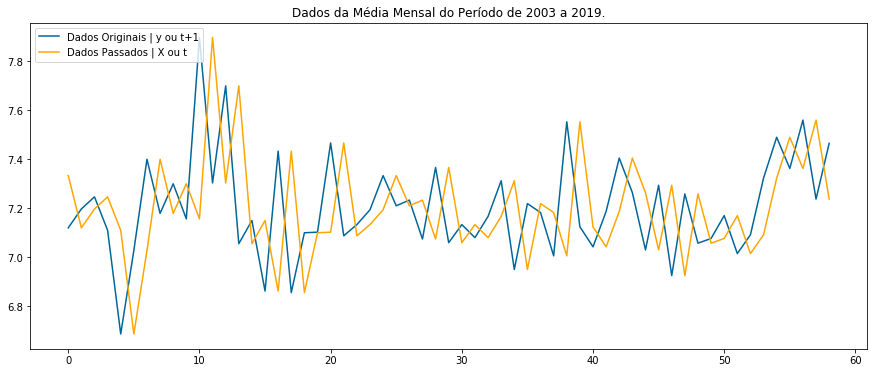

In [260]:
TRAIN_SIZE = 0.70
train_size = int(len(pts_mes_valor) * TRAIN_SIZE)
test_size = len(pts_mes_valor) - train_size
train, test = pts_mes_valor[0:train_size], pts_mes_valor[train_size:len(pts_mes_valor)]
print('Numero de observações (dados de treino, dados de teste): ' + str((len(train),len(test))))

def prepare_data(data, lags=1):
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags)]
        X.append(a)
        y.append(data[row + lags])
    return np.array(X), np.array(y) 

lags = 1
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test

plt.plot(y_test, label='Dados Originais | y ou t+1', color='#006699')
plt.plot(X_test, label='Dados Passados | X ou t', color='orange')
plt.legend(loc='upper left')
plt.title('Dados da Média Mensal do Período de 2003 a 2019.')
plt.show()

In [261]:
mdl = Sequential()
mdl.add(Dense(4, input_dim=lags, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=100, batch_size=2, verbose=2)

Train on 138 samples
Epoch 1/100
138/138 - 1s - loss: 58.3107
Epoch 2/100
138/138 - 0s - loss: 42.7780
Epoch 3/100
138/138 - 0s - loss: 30.3053
Epoch 4/100
138/138 - 0s - loss: 20.4926
Epoch 5/100
138/138 - 0s - loss: 13.0705
Epoch 6/100
138/138 - 0s - loss: 7.7677
Epoch 7/100
138/138 - 0s - loss: 4.2735
Epoch 8/100
138/138 - 0s - loss: 2.1764
Epoch 9/100
138/138 - 0s - loss: 1.0415
Epoch 10/100
138/138 - 0s - loss: 0.4981
Epoch 11/100
138/138 - 0s - loss: 0.2637
Epoch 12/100
138/138 - 0s - loss: 0.1759
Epoch 13/100
138/138 - 0s - loss: 0.1460
Epoch 14/100
138/138 - 0s - loss: 0.1364
Epoch 15/100
138/138 - 0s - loss: 0.1343
Epoch 16/100
138/138 - 0s - loss: 0.1335
Epoch 17/100
138/138 - 0s - loss: 0.1339
Epoch 18/100
138/138 - 0s - loss: 0.1330
Epoch 19/100
138/138 - 0s - loss: 0.1333
Epoch 20/100
138/138 - 0s - loss: 0.1333
Epoch 21/100
138/138 - 0s - loss: 0.1338
Epoch 22/100
138/138 - 0s - loss: 0.1340
Epoch 23/100
138/138 - 0s - loss: 0.1335
Epoch 24/100
138/138 - 0s - loss: 0.1330

In [262]:
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Pontuação de teste: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Pontuação de Treino: 0.13 MSE (0.36 RMSE)
Pontuação de teste: 0.07 MSE (0.27 RMSE)


In [263]:
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

In [264]:
train_predict_plot = np.empty_like(pts_mes_valor)
train_predict_plot = np.reshape(train_predict_plot,(train_predict_plot.shape[0],1))
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

In [265]:
test_predict_plot = np.empty_like(pts_mes_valor)
test_predict_plot = np.reshape(test_predict_plot,(test_predict_plot.shape[0],1))
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(pts_mes_valor)-1, :] = test_predict

In [267]:
valor_preditos = np.concatenate((train_predict,test_predict),axis=None)

phts_mes = pts_mes['2003-01-01':'2019-12-31']

for i in range(len(valor_preditos)):
    phts_mes[i] = valor_preditos[i]
    print("Valor Predito: ", valor_preditos[i])
    print("phts_mes: ", phts_mes[i])
    print("pts_mes: ", pts_mes[i])
    

Valor Predito:  6.948972
phts_mes:  6.948972225189209
pts_mes:  6.948972225189209
Valor Predito:  7.4484982
phts_mes:  7.448498249053955
pts_mes:  7.448498249053955
Valor Predito:  6.9999437
phts_mes:  6.999943733215332
pts_mes:  6.999943733215332
Valor Predito:  7.5300536
phts_mes:  7.530053615570068
pts_mes:  7.530053615570068
Valor Predito:  7.088296
phts_mes:  7.088295936584473
pts_mes:  7.088295936584473
Valor Predito:  7.2853875
phts_mes:  7.2853875160217285
pts_mes:  7.2853875160217285
Valor Predito:  7.101888
phts_mes:  7.101888179779053
pts_mes:  7.101888179779053
Valor Predito:  7.774719
phts_mes:  7.77471923828125
pts_mes:  7.77471923828125
Valor Predito:  7.137569
phts_mes:  7.137568950653076
pts_mes:  7.137568950653076
Valor Predito:  7.4484982
phts_mes:  7.448498249053955
pts_mes:  7.448498249053955
Valor Predito:  7.132472
phts_mes:  7.132472038269043
pts_mes:  7.132472038269043
Valor Predito:  6.4698353
phts_mes:  6.46983528137207
pts_mes:  6.46983528137207
Valor Predit

Valor Predito:  7.114122
phts_mes:  7.114121913909912
pts_mes:  7.114121913909912
Valor Predito:  7.2127647
phts_mes:  7.212764739990234
pts_mes:  7.212764739990234
Valor Predito:  6.902078
phts_mes:  6.902078151702881
pts_mes:  6.902078151702881
Valor Predito:  7.0783925
phts_mes:  7.078392505645752
pts_mes:  7.078392505645752
Valor Predito:  7.3479133
phts_mes:  7.3479132652282715
pts_mes:  7.3479132652282715
Valor Predito:  7.1063366
phts_mes:  7.10633659362793
pts_mes:  7.10633659362793
Valor Predito:  7.1956773
phts_mes:  7.195677280426025
pts_mes:  7.195677280426025
Valor Predito:  7.2026677
phts_mes:  7.202667713165283
pts_mes:  7.202667713165283
Valor Predito:  7.4349055
phts_mes:  7.434905529022217
pts_mes:  7.434905529022217
Valor Predito:  7.3125734
phts_mes:  7.312573432922363
pts_mes:  7.312573432922363
Valor Predito:  7.138588
phts_mes:  7.138587951660156
pts_mes:  7.138587951660156
Valor Predito:  7.2015023
phts_mes:  7.201502323150635
pts_mes:  7.201502323150635
Valor P

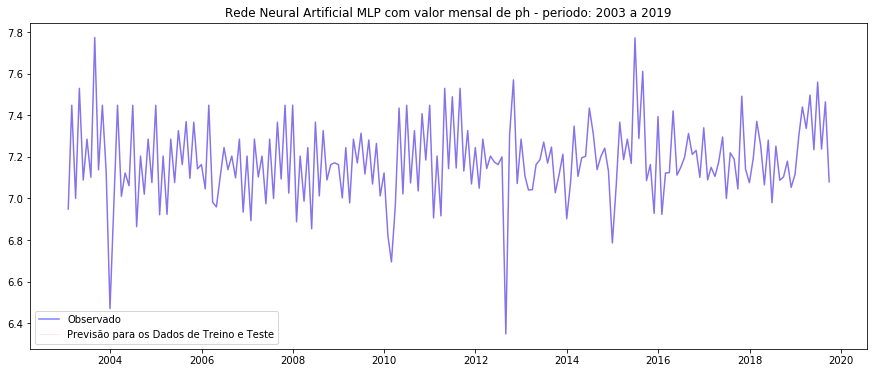

In [268]:
plt.plot(pts_mes, label='Observado', color='Blue',alpha=0.5);
#plt.plot(train_predict_plot, label='Previsão para os Dados de Treino', color='blue', alpha=0.5);
plt.plot(phts_mes, label='Previsão para os Dados de Treino e Teste', color='red',alpha=0.2,linewidth=0.5);
plt.legend(loc='best');
plt.title('Rede Neural Artificial MLP com valor mensal de ph - periodo: 2003 a 2019')
plt.show()

In [269]:
tdf
df6 = tdf[ (tdf.UGRHI == '06 - ALTO TIÊTE') ]
df10 = tdf[ (tdf.UGRHI == '10 - SOROCABA/MEDIO TIETE') ]

df16 = pd.concat([df6,df10])
df16

,periodode,periodoate,cod_interaguas,tipo_rede,UGRHI,codigo_ponto,status_ponto,hora_coleta,parametro,sinal,...,classe,municipio,uf,inicio_operacao,fim_operacao,Latitude,Longitude,Altitude,Localizacao,Captacao
data_coleta,,,,,,,,,,,,,,,,,,,,,
1978-01-01,01/01/1974,28/12/2019,124,Rede Básica,06 - ALTO TIÊTE,TIES04900,Ativo,12:00,pH,NaN,...,Classe 4,SANTANA DO PARNAIBA,SP,01/01/1976,NaN,23 27 16,46 54 36,716,Próximo às comportas da barragem do reservatór...,N
1978-02-01,01/01/1974,28/12/2019,124,Rede Básica,06 - ALTO TIÊTE,TIES04900,Ativo,12:00,pH,NaN,...,Classe 4,SANTANA DO PARNAIBA,SP,01/01/1976,NaN,23 27 16,46 54 36,716,Próximo às comportas da barragem do reservatór...,N
1978-03-01,01/01/1974,28/12/2019,124,Rede Básica,06 - ALTO TIÊTE,TIES04900,Ativo,12:00,pH,NaN,...,Classe 4,SANTANA DO PARNAIBA,SP,01/01/1976,NaN,23 27 16,46 54 36,716,Próximo às comportas da barragem do reservatór...,N
1978-04-01,01/01/1974,28/12/2019,124,Rede Básica,06 - ALTO TIÊTE,TIES04900,Ativo,12:00,pH,NaN,...,Classe 4,SANTANA DO PARNAIBA,SP,01/01/1976,NaN,23 27 16,46 54 36,716,Próximo às comportas da barragem do reservatór...,N
1978-05-01,01/01/1974,28/12/2019,124,Rede Básica,06 - ALTO TIÊTE,TIES04900,Ativo,12:00,pH,NaN,...,Classe 4,SANTANA DO PARNAIBA,SP,01/01/1976,NaN,23 27 16,46 54 36,716,Próximo às comportas da barragem do reservatór...,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-03,01/01/1974,28/12/2019,128,Rede Básica,10 - SOROCABA/MEDIO TIETE,TIRG02900,Ativo,11:30,pH,NaN,...,Classe 2,PIRAPORA DO BOM JESUS,SP,01/01/1998,NaN,23 22 58,47 01 46,669,Próximo das comportas do Reservatório de Rasgão.,N
2018-07-12,01/01/1974,28/12/2019,128,Rede Básica,10 - SOROCABA/MEDIO TIETE,TIRG02900,Ativo,11:30,pH,NaN,...,Classe 2,PIRAPORA DO BOM JESUS,SP,01/01/1998,NaN,23 22 58,47 01 46,669,Próximo das comportas do Reservatório de Rasgão.,N
2018-09-25,01/01/1974,28/12/2019,128,Rede Básica,10 - SOROCABA/MEDIO TIETE,TIRG02900,Ativo,14:30,pH,NaN,...,Classe 2,PIRAPORA DO BOM JESUS,SP,01/01/1998,NaN,23 22 58,47 01 46,669,Próximo das comportas do Reservatório de Rasgão.,N


Observando o comportamento da serie temporal no período de 1977 a 2019 - Alto Tiête
data_coleta
1978-01-01    7.10
1978-02-01    6.60
1978-03-01    6.60
1978-04-01    6.70
1978-05-01    7.10
              ... 
2019-04-25    7.41
2019-05-16    7.43
2019-06-06    7.58
2019-07-04    7.17
2019-08-01    7.39
Name: valor, Length: 2257, dtype: float64


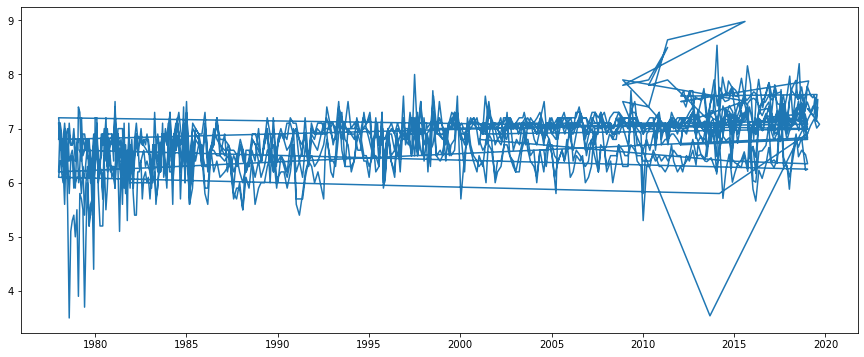

Calcula a média do valor de pH por mês no período de 1977 a 2019.
data_coleta
1978-01-31    6.6800
1978-02-28    6.8200
1978-03-31    6.5400
1978-04-30    6.3400
1978-05-31    6.5400
               ...  
2019-05-31    7.3625
2019-06-30    7.5600
2019-07-31    7.2375
2019-08-31    7.4650
2019-09-30    7.0800
Freq: M, Name: valor, Length: 501, dtype: float64


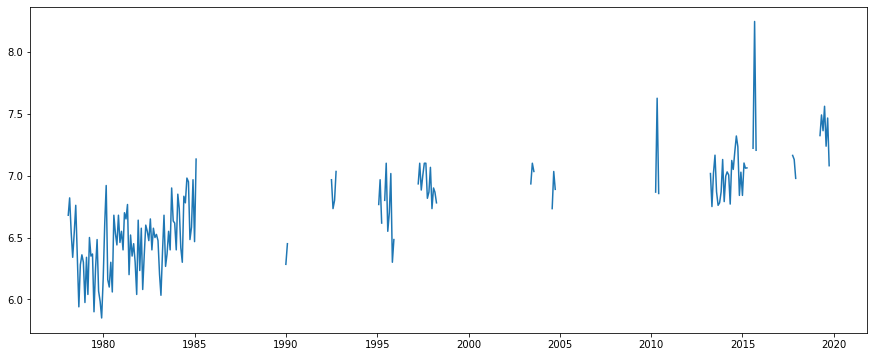

Total de observações Mensais: 501


In [270]:
ts6 = df6['valor']
print("Observando o comportamento da serie temporal no período de 1977 a 2019 - Alto Tiête")
pts6 = ts6['1977-01-01':'2019-12-31']
print(pts6)
plt.plot(pts6)
plt.show()

print("Calcula a média do valor de pH por mês no período de 1977 a 2019.")
pts_mes6 = pts6.resample('M').mean()
print(pts_mes6)
plt.plot(pts_mes6)
plt.show()
print("Total de observações Mensais:", len(pts_mes6))

Observando o comportamento da serie temporal no período de 1977 a 2019 - SOROCABA/MEDIO TIETE
data_coleta
1995-02-08    6.90
1995-04-03    6.70
1995-05-24    6.60
1995-06-26    6.60
1995-07-12    6.60
              ... 
2018-05-03    7.29
2018-07-12    7.65
2018-09-25    7.18
2018-11-21    7.00
2019-01-09    6.98
Name: valor, Length: 1431, dtype: float64


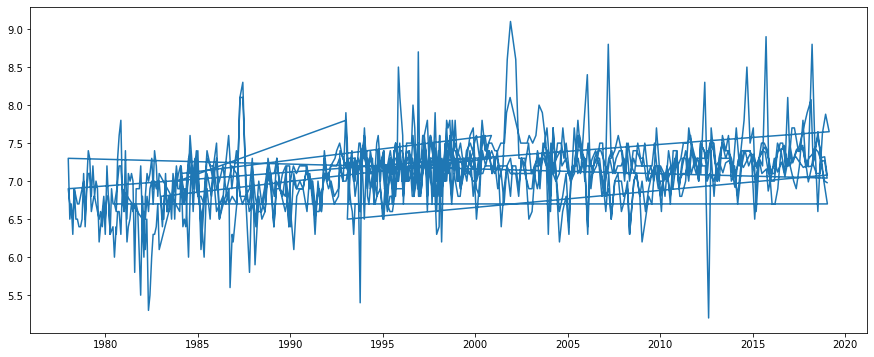

Calcula a média do valor de pH por mês no período de 1977 a 2019.
data_coleta
1978-01-31    7.1000
1978-02-28    6.6000
1978-03-31    6.6500
1978-04-30    6.4000
1978-05-31    6.9000
               ...  
2018-10-31    7.6300
2018-11-30    7.1475
2018-12-31    7.8800
2019-01-31    6.9500
2019-02-28    7.6500
Freq: M, Name: valor, Length: 494, dtype: float64


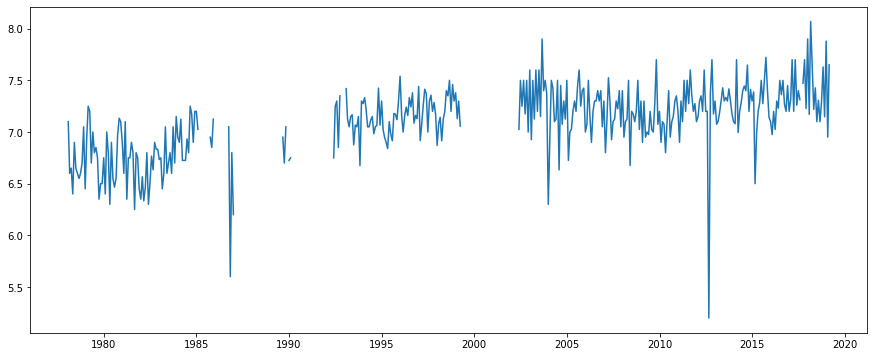

Total de observações Mensais: 494


In [271]:
ts10 = df10['valor']
print("Observando o comportamento da serie temporal no período de 1977 a 2019 - SOROCABA/MEDIO TIETE")
pts10 = ts10['1977-01-01':'2019-12-31']
print(pts10)
plt.plot(pts10)
plt.show()

print("Calcula a média do valor de pH por mês no período de 1977 a 2019.")
pts_mes10 = pts10.resample('M').mean()
print(pts_mes10)
plt.plot(pts_mes10)
plt.show()
print("Total de observações Mensais:", len(pts_mes10))

Observando o comportamento da serie temporal no período de 1977 a 2019, das UGRHI: Alto Tiête e SOROCABA/MEDIO TIETE.
data_coleta
1978-01-01    7.10
1978-02-01    6.60
1978-03-01    6.60
1978-04-01    6.70
1978-05-01    7.10
              ... 
2018-05-03    7.29
2018-07-12    7.65
2018-09-25    7.18
2018-11-21    7.00
2019-01-09    6.98
Name: valor, Length: 3688, dtype: float64


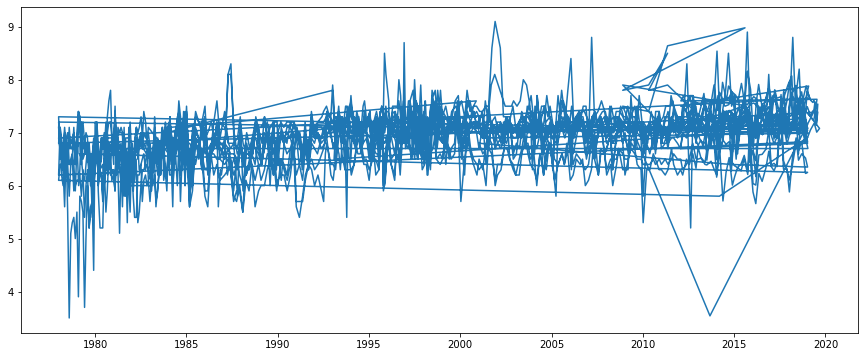

Calcula a média do valor de pH por mês no período de 1977 a 2019.
 Observa-se a ausência de valores durante a série temporal.
data_coleta
1978-01-31    6.800000
1978-02-28    6.757143
1978-03-31    6.571429
1978-04-30    6.357143
1978-05-31    6.642857
                ...   
2019-05-31    7.362500
2019-06-30    7.560000
2019-07-31    7.237500
2019-08-31    7.465000
2019-09-30    7.080000
Freq: M, Name: valor, Length: 501, dtype: float64


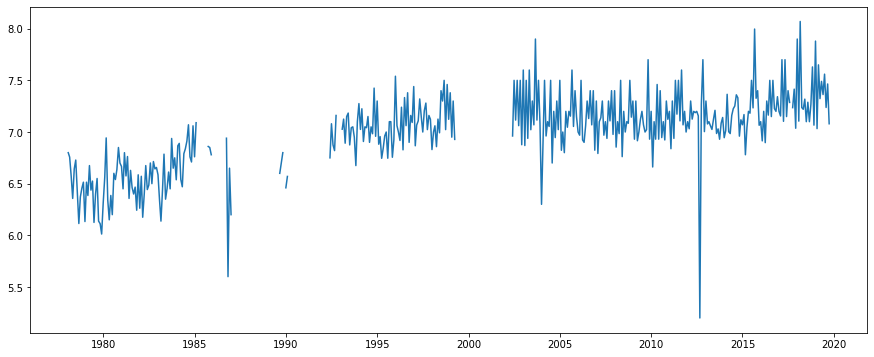

Total de observações: 501


In [272]:
ts16 = df16['valor']

print("Observando o comportamento da serie temporal no período de 1977 a 2019, das UGRHI: Alto Tiête e SOROCABA/MEDIO TIETE.")
pts16 = ts16['1977-01-01':'2019-12-31']
print(pts16)
plt.plot(pts16)
plt.show()

print("Calcula a média do valor de pH por mês no período de 1977 a 2019.\n Observa-se a ausência de valores durante a série temporal.")
pts_mes16 = pts16.resample('M').mean()
print(pts_mes16)
plt.plot(pts_mes16)
plt.show()
print("Total de observações:", len(pts_mes16))

In [ ]:
df6.describe()

In [240]:
df10.describe()

,cod_interaguas,sinal,valor,Altitude
count,1431.000000,0.0,1431.000000,1431.000000
mean,149.283718,NaN,7.101251,543.723969
std,17.329889,NaN,0.381870,89.573824
min,127.000000,NaN,5.200000,460.000000
25%,128.000000,NaN,6.900000,474.000000
50%,151.000000,NaN,7.100000,508.000000
75%,166.000000,NaN,7.300000,669.000000
max,177.000000,NaN,9.100000,670.000000


In [241]:
df16.describe()

,cod_interaguas,sinal,valor,Altitude
count,3688.000000,0.0,3688.000000,3688.000000
mean,267.770065,NaN,6.928015,651.322668
std,449.860323,NaN,0.466143,103.450914
min,110.000000,NaN,3.500000,460.000000
25%,124.000000,NaN,6.700000,560.000000
50%,132.000000,NaN,7.000000,700.000000
75%,166.000000,NaN,7.200000,735.000000
max,2582.000000,NaN,9.100000,784.000000
